In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-division-encodingandfitting/flight_weather.csv
/kaggle/input/data-division-encodingandfitting/encoded_flight_weather.csv
/kaggle/input/data-division-encodingandfitting/encoded_flight_wn.csv
/kaggle/input/data-division-encodingandfitting/custom.css
/kaggle/input/data-division-encodingandfitting/__notebook__.ipynb
/kaggle/input/data-division-encodingandfitting/__results__.html
/kaggle/input/data-division-encodingandfitting/__output__.json
/kaggle/input/data-division-encodingandfitting/flight_wn.csv


In [8]:
from sklearn.model_selection import train_test_split

import category_encoders as ce 
from sklearn.pipeline import Pipeline

import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.ensemble import StackingRegressor

In [2]:
df=pd.read_csv("/kaggle/input/data-division-encodingandfitting/flight_wn.csv")

In [10]:
# x=df[['MONTH','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DISTANCE']]
# y=df['ARRIVAL_DELAY']
train,test=train_test_split(df,test_size=0.35)


In [3]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY,Date
0,1,1,4,WN,SFO,DEN,-2.0,967,-2.0,2015-01-01
1,1,1,4,WN,BOS,BWI,-4.0,369,-26.0,2015-01-01
2,1,1,4,WN,LAS,BWI,2.0,2106,-25.0,2015-01-01
3,1,1,4,WN,ABQ,HOU,7.0,759,22.0,2015-01-01
4,1,1,4,WN,PHX,SLC,1.0,507,-6.0,2015-01-01


In [7]:
len(df['MONTH'].value_counts())


12

In [12]:
encoding_pipeline = Pipeline([
#   ('encode_airline', ce.HashingEncoder(n_components=15, cols=['AIRLINE'],return_df=True)),
  ('encode_origin', ce.cat_boost.CatBoostEncoder(cols=['ORIGIN_AIRPORT'], return_df=True)),
  ('encode_destination', ce.cat_boost.CatBoostEncoder(cols=['DESTINATION_AIRPORT'], return_df=True)),
  ('encode_month', ce.cat_boost.CatBoostEncoder(cols=['MONTH'], return_df=True))
])

# Get the encoded dataset:
train_e = encoding_pipeline.fit_transform(train, train['ARRIVAL_DELAY'])
test_e=encoding_pipeline.transform(test)


In [14]:
train_ex=train_e[['MONTH','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DISTANCE']].to_numpy()
train_ey=train_e['ARRIVAL_DELAY'].to_numpy()
test_ex=test_e[['MONTH','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DISTANCE']].to_numpy()

In [15]:
level0 = list()
level0.append(('knn', KNeighborsRegressor()))
level0.append(('cart', DecisionTreeRegressor()))

# define meta learner model
level1 = LinearRegression()

In [16]:
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

In [17]:
model.fit(train_ex,train_ey)

StackingRegressor(cv=5,
                  estimators=[('knn',
                               KNeighborsRegressor(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                              ('cart',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                  

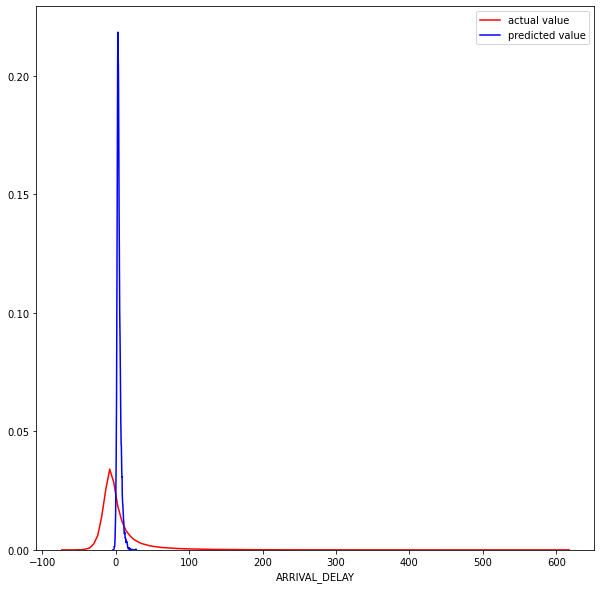

In [18]:
yhat = model.predict(test_ex)
plt.figure(figsize=(10,10))
ax1=sns.distplot(test_e['ARRIVAL_DELAY'],hist=False,color='r',label='actual value')
ax2=sns.distplot(yhat,hist=False,color='blue',label='predicted value')